## Preparing Enviornment

In [1]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
import spacy
from spacy.training.example import Example
import random
import matplotlib.pyplot as plt
# import IPython.core.display as display

## Reformatting the Annotation Tags into Training Data
TODO: Break into sentences when processing the documents
* Could use swahili sent tokenizer, or use nltk tokenizer to break on the periods (edge case could be titles)

In [3]:
with open("annotations-bbc-swahili.json", "r") as f:
    data = json.load(f)


In [4]:
article_test = data[1]["data"]["Text"]
sentence_test = []
sentence_test = data[1]["data"]["Text"].split(".") # puts every sentence in a list
print(data[0]["annotations"][0]["result"][1]["value"])

{'start': 59, 'end': 64, 'text': 'Kenya', 'labels': ['GPE']}


In [ ]:
with open("annotations-bbc-swahili.json", "r") as f:
    data = json.load(f)

training_data = []

for item in data:
    sentences = item["data"]["Text"].split(".") 
    for i, sentence in enumerate(sentences):
        entities = []    # takes the annotations
        if i == 0:
            prev_sent_len = 0
        else:
            prev_sent_len = sent_len
        sent_len = len(sentence) + 1 + prev_sent_len  # +1 for the period at the end of the sentence
        for tag in item["annotations"][0]["result"]: # check tag indexes against sent_len and append the tags to entitieslist for that sentence only
            if tag["value"]["start"] >= prev_sent_len and tag["value"]["end"] <= sent_len: 
                entities.append((tag["value"]["start"], tag["value"]["end"], tag["value"]["labels"][0]))
        
        training_data.append((sentence, {"entities": entities}))

In [ ]:
import re
with open("annotations-bbc-swahili.json", "r") as f:
    data = json.load(f)

training_data = []

for item in data:
    sentences = item["data"]["Text"]
    sent_len = 0  # initialize sentence length
    for match in re.finditer(r'(?<=[.!?]) +', sentences):  # split by sentence-ending punctuation
        sent = match.group().strip()
        print(f"sentence here: {sentence}")
        if sent:
            sent_start = match.start()
            sent_end = match.end()
            sentences.append((sent, sent_start, sent_end))
            print(f"Sentence: {sent}, Start: {sent_start}, End: {sent_end}")
    # for sentence in sentences:
    #     entities = []
    #     for tag in item["annotations"][0]["result"]:
    #         ent_start = tag["value"]["start"]
    #         ent_end = tag["value"]["end"]
    #         if ent_start >= sent_start and ent_end <= sent_end:
    #             # Adjust to sentence-relative indices
    #             entities.append((ent_start - sent_start, ent_end - sent_start, tag["value"]["labels"][0]))
        # training_data.append((sent, {"entities": entities}))
        # entities = []    # takes the annotations
        # if i == 0:
        #     prev_sent_len = 0
        # else:
        #     prev_sent_len = sent_len
        # sent_len = len(sentence) + 1 + prev_sent_len  # +1 for the period at the end of the sentence
        # for tag in item["annotations"][0]["result"]: # check tag indexes against sent_len and append the tags to entitieslist for that sentence only
        #     if tag["value"]["start"] >= prev_sent_len and tag["value"]["end"] <= sent_len: 
        #         entities.append((tag["value"]["start"], tag["value"]["end"], tag["value"]["labels"][0]))
        
        # training_data.append((sentence, {"entities": entities}))

In [ ]:
for sent, ann in training_data[:5]:
    print(repr(sent), ann)

In [35]:
training_data

[('CHANZO CHA PICHA,\nAFP\nKati ya mwezi Januari na Machi 2025, Kenya ilikumbwa na janga kubwa la mauaji ya wanawake, ambapo jumla ya wanawake 129 waliripotiwa kuuawa',
  {'entities': [(30, 58, 'DATE'), (59, 64, 'GPE')]}),
 ('\nMnamo Januari, wanawake 43 waliuawa, wakifuatiwa na 42 mnamo Februari, na 44 mnamo Machi',
  {'entities': [(169, 176, 'DATE'), (224, 232, 'DATE'), (246, 251, 'DATE')]}),
 ('\nMaeneo ya Bonde la Ufa, Mashariki, na Magharibi yaliandikisha idadi ya juu zaidi ya vifo hivyo',
  {'entities': [(263, 275, 'GPE'), (277, 286, 'GPE'), (291, 300, 'GPE')]}),
 ('\nTakwimu zinaonyesha kuwa wanaume walihusika na asilimia 85 ya mauaji haya, huku wanawake wakihusishwa na asilimia 10',
  {'entities': []}),
 ('\nKatika visa vingi, wahalifu walikuwa watu waliowafahamu waathiriwa, na nusu ya mauaji haya yalihusiana na migogoro ya kifamilia',
  {'entities': []}),
 ('\nKwa mwaka wa 2024 pekee, jumla ya visa 579 za mauaji ya wanawake ziliripotiwa',
  {'entities': [(600, 613, 'DATE')]}),

In [ ]:
# idr what this was for tbh
test_train = annotations_to_spacy("BBC_swahili_afya_0-5.json")
combination = train_data + test_train
# for article in test_train:
#     train_data.append(article)
print("Number of training examples:", len(combination))

Number of training examples: 10


In [38]:
print(training_data[5][1]["entities"])

[(600, 613, 'DATE')]


In [36]:
print(f"Training data: {len(training_data)}" )

Training data: 194


## Training the Model

In [42]:
train, temp = train_test_split(training_data, test_size=0.8, random_state=42)
dev, test = train_test_split(temp, test_size=0.2, random_state=42)

print(f"Train: {len(train)}, Dev: {len(dev)}, and Test: {len(test)}")

Train: 38, Dev: 124, and Test: 32


In [43]:
swah_ner = spacy.blank("xx")

ner = swah_ner.add_pipe("ner")

for _, annotations in train:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Initialize the model
optimizer = swah_ner.begin_training()

loss_plot = [] # Initialize an empty list to for loss value graph

for i in range(7): #changed because of overfitting
    random.shuffle(train)
    losses = {}
    for text, annotations in train:
        example = Example.from_dict(swah_ner.make_doc(text), annotations) #so this line of code creates a new Example object from a doc object and the annotations as well as a dictionary
        # had an error w overlapping ents (JMI overlapped w GPE) so I need to use spans
        swah_ner.update([example], sgd=optimizer, drop=0.5, losses=losses)
    loss_plot.append(losses["ner"])  # Store the NER loss
    print(f"Loss at epoch {i+1}: {losses['ner']}")

Loss at epoch 1: 177.71893310546875
Loss at epoch 2: 0.0036894744262099266
Loss at epoch 3: 0.00017143282457254827
Loss at epoch 4: 8.64975754666375e-06
Loss at epoch 5: 0.0014108906034380198
Loss at epoch 6: 1.8794570451063919e-06
Loss at epoch 7: 6.629871762697803e-08


In [46]:
swah_ner.to_disk("swahili_ner_model_lite_v2")

### Visualizaing the Model

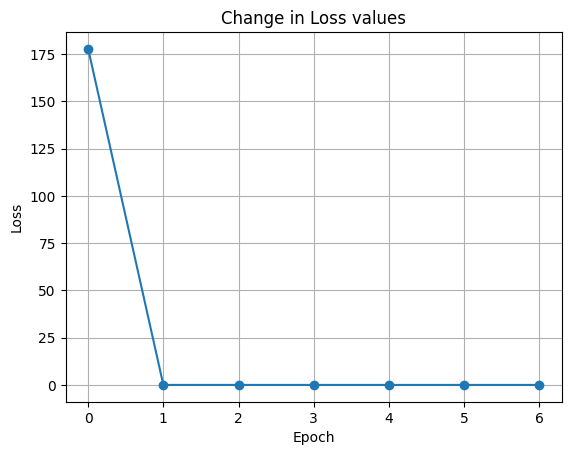

In [45]:
plt.plot(range(7), loss_plot, marker='o')
plt.title("Change in Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
# plt.savefig("loss_plot_3.png")
plt.show()

### Loading Model

In [51]:
test_model = spacy.load("swahili_ner_model_lite_v2")
# train[0][0]
sample_text = train[0][0]
doc = test_model(sample_text)
print([(ent.text, ent.label_) for ent in doc.ents])

[]


In [52]:
from spacy import displacy
test_text = """
        Mti huu unaopatikana katika kisiwa cha Socotra nchini Yemen, hujulikana kwa jina la kisayansi Dracaena cinnabari. Muonekano wake wa kipekee kama mwavuli unaofunguka juu, pamoja na utokaji wa utomvu mwekundu kama damu, umekuwa ukivutia watafiti kwa karne nyingi.
        Kwa mujibu wa World Wildlife Fund (WWF), mti huu ni kiashiria cha urithi wa kipekee wa visiwa vya Socotra ambavyo vina zaidi ya 700 ya spishi adimu zisizopatikana kwingine duniani.
        Shughuli za ufugaji usio endelevu, ukataji miti na mabadiliko ya tabianchi vinaweka spishi hii katika hatari. Shirika la UNESCO limeitaja Socotra kama moja ya sehemu za urithi wa dunia na juhudi za uhifadhi zinafanywa kwa kushirikiana na wadau wa kimataifa.
        Kwa mujibu wa orodha iliyotolewa na IUCN (2023), mti huu unaorodheshwa kama mti ulio hatua moja kabla ya kuingia kwenye kundi la mimea iliyoko hatarini kutoweka.
       """
doc = swah_ner(test_text)

print("Entities found:", len(doc.ents))
print([(ent.text, ent.label_) for ent in doc.ents])
for ent in doc.ents:
    print("here")
    print(ent.text, ent.label_)

Entities found: 0
[]


In [63]:
for sent, ann in training_data[:5]:
    print(repr(sent), ann)

'CHANZO CHA PICHA,\nAFP\nKati ya mwezi Januari na Machi 2025, Kenya ilikumbwa na janga kubwa la mauaji ya wanawake, ambapo jumla ya wanawake 129 waliripotiwa kuuawa' {'entities': [(30, 58, 'DATE'), (59, 64, 'GPE')]}
'\nMnamo Januari, wanawake 43 waliuawa, wakifuatiwa na 42 mnamo Februari, na 44 mnamo Machi' {'entities': [(169, 176, 'DATE'), (224, 232, 'DATE'), (246, 251, 'DATE')]}
'\nMaeneo ya Bonde la Ufa, Mashariki, na Magharibi yaliandikisha idadi ya juu zaidi ya vifo hivyo' {'entities': [(263, 275, 'GPE'), (277, 286, 'GPE'), (291, 300, 'GPE')]}
'\nTakwimu zinaonyesha kuwa wanaume walihusika na asilimia 85 ya mauaji haya, huku wanawake wakihusishwa na asilimia 10' {'entities': []}
'\nKatika visa vingi, wahalifu walikuwa watu waliowafahamu waathiriwa, na nusu ya mauaji haya yalihusiana na migogoro ya kifamilia' {'entities': []}
